# Data Challenge 8 — Introduction to Multiple Linear Regression (MLR)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)


**Goal:** Build an **MLR** model using **2–3 predictors** to predict one numeric target. Evaluate with a **train–test split** (MAE/RMSE), interpret **coefficients while holding others constant**, and compare against an **SLR baseline**.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Docs (quick links):**
- Train/Test Split — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (`resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html


### Pseudocode Plan (for **MLR**)
1) **Load CSV** → preview columns/shape.
2) **Assign Y and Xs (2–3 predictors)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X_matrix)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one‑liner** → MAE/RMSE in units + brief reliability note. *(Optional)* Contrast with an **SLR baseline** using the strongest single predictor.

## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
# Load dataset
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')

/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_57737/3649520389.py:2: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


In [3]:
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0000,0.69,1.0000,N,141,140,1,7.9000,2.5000,0.5000,3.0000,0.0000,1.0000,17.4000,2.5000,0.0000
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0000,1.1,1.0000,N,236,263,2,10.0000,5.0000,0.5000,0.0000,0.0000,1.0000,16.5000,2.5000,0.0000
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,-10.7000,-2.5000,-0.5000,0.0000,0.0000,-1.0000,-17.2000,-2.5000,0.0000
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,10.7000,2.5000,0.5000,0.0000,0.0000,1.0000,17.2000,2.5000,0.0000
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0000,3,1.0000,N,164,211,1,21.9000,5.0000,0.5000,3.0000,0.0000,1.0000,31.4000,2.5000,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,"3,310,907.0000","3,133,527.0000","3,133,527.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,133,527.0000","3,133,527.0000"
mean,1.7504,1.4096,1.7850,165.0685,163.9182,1.1686,1.4852,0.4829,0.5734,0.9758,2.2700,0.1368
std,0.4356,0.9117,8.2833,64.2833,69.6845,0.5960,1.8141,0.1207,2.2285,0.2171,0.8078,0.4797
min,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,-39.1700,-0.5000,-70.0000,-1.0000,-2.5000,-1.7500
25%,1.0000,1.0000,1.0000,132.0000,113.0000,1.0000,0.0000,0.5000,0.0000,1.0000,2.5000,0.0000
50%,2.0000,1.0000,1.0000,162.0000,162.0000,1.0000,1.0000,0.5000,0.0000,1.0000,2.5000,0.0000
75%,2.0000,2.0000,1.0000,234.0000,234.0000,1.0000,2.5000,0.5000,0.0000,1.0000,2.5000,0.0000
max,6.0000,9.0000,99.0000,265.0000,265.0000,4.0000,51.6800,42.1700,161.3800,1.0000,2.5000,1.7500


In [4]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')

In [5]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])


/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_57737/2585414384.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])


In [6]:
df = df[(df['tpep_pickup_datetime'] >= '2023-12-01') & (df['tpep_pickup_datetime'] < '2024-01-01')]

In [7]:
df.shape

(3310901, 19)

In [8]:
df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          177380
trip_distance                 0
RatecodeID               177380
store_and_fwd_flag       177380
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     177380
airport_fee              177380
dtype: int64

### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

The response variable (Y) I chose is `fare_amount`, representing the fare charged for a taxi trip. I think this outcome is meaningful for my stakeholders `taxi company`, who aim to understand which trip factors most influence earnings. My stakeholders can act on this information to optimize pricing, scheduling, and customer service strategies. 
And the x-variable I chose are `trip_distance` because longer trips lead to higher fares, this is the single strongest predictor of total amount and also, `passenger_count` because if the number of people increase, that could encrease the fare amount as well meaning more effort for the driver sometimes to help with laugage


In [9]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count', 'total_amount']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')
# Clean data some and add a new column called ‘tip_pct’ as the target
df = df[(df['trip_distance'] > 0) & (df['passenger_count'] > 0) & (df['total_amount'] > 0) & (df['fare_amount'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)

In [10]:
list_col = ['fare_amount', 'trip_distance', 'passenger_count']
for _ in list_col:
    Q1 = df[_].quantile(0.25)
    Q3 = df[_].quantile(0.99)
    IQR = Q3 - Q1
    df = df[(df[_] >= Q1 - 1.5*IQR) & (df[_] <= Q3 + 1.5*IQR)]

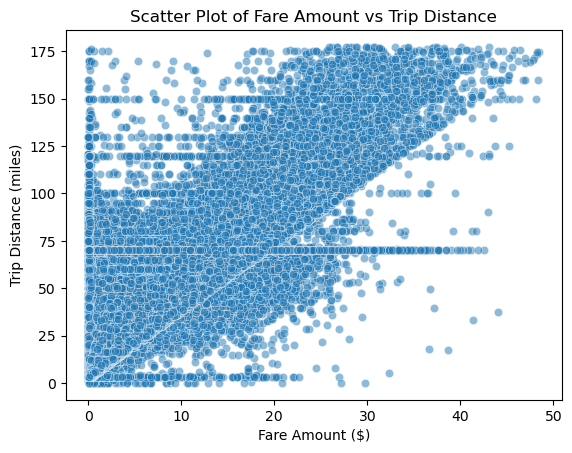

In [11]:
import seaborn as sns
sns.scatterplot(data=df, x='trip_distance', y='fare_amount', alpha=0.5)
plt.title('Scatter Plot of Fare Amount vs Trip Distance')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Trip Distance (miles)')
plt.show()

### Step 3 —  Design Matrix (add intercept) & Train–Test Split (80/20)

- Add intercept with `sm.add_constant`.
- Use a **random_state** for reproducibility.
- (Optional) Discuss when a **time‑aware** split is better.

In [12]:
# Let's  Perform the Train-Test Split
# Prepare X data with constant
X = sm.add_constant(df[['trip_distance', 'passenger_count']]) 
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")

Training data shape: (2411461, 3)
Testing data shape:  (602866, 3)


### Step 4 — Fit MLR on TRAIN & Interpret Coefficients (holding others constant)

- Print the **coefficient table**.
- Write **one unit‑based sentence per coefficient** using “**holding others constant**.”

In [13]:
X_train.head()

,const,trip_distance,passenger_count
259997,1.0000,2.0700,1.0000
482999,1.0000,2.7500,1.0000
799435,1.0000,2.1300,1.0000
1961905,1.0000,4.0200,1.0000
2171884,1.0000,17.7100,4.0000


In [14]:
X_test.head()

,const,trip_distance,passenger_count
2687153,1.0000,1.3600,1.0000
1650738,1.0000,1.0400,1.0000
2635474,1.0000,2.9700,1.0000
1045862,1.0000,1.9500,2.0000
922477,1.0000,1.8400,1.0000


In [15]:
# --- Train the model ONLY on the training data ---
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 8.061e+06
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:32:24   Log-Likelihood:            -7.8053e+06
No. Observations:             2411461   AIC:                         1.561e+07
Df Residuals:                 2411458   BIC:                         1.561e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.1868      0.008    9

*Template (edit to your variables & units):*
- **β_intercept (const):** The baseline of our outcome `fare amount` is 7$ and 18¢ when all the predictor variables are 0.
- **β_X1:** Holding other predictors constant, +1 mile in **Trip distance** is associated with **+3.66** dollar in **Fare amount**.
- **β_X2:** Holding other predictors constant, +1 passenger in **Passenger count** is associated with **+0.28** dollar in **Fare amount**.
- **Significance:** a p-value of 0.000 show a statistically significance between `Fare amount`, `trip distance` and `passenger count`, meaning the encrease of fare amount likely due to the predictor variable, it is not due to a random chance. and each extra mile and passenger count are associated with +7$ in the fare amount (97%CI [0.025, 0.975]). 

### Step 5 — Evaluate on **Unseen Test Data** (MAE/RMSE in units of Y)
Compute MAE and RMSE and write a one‑sentence **stakeholder** readout.

In [ ]:
# Now let's evaluate the model on the unseen testing data 
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nMean Absolute Error (MAE) on Test Data: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.2f}")
print(f"\nInterpretation: Our model's predictions on new data are off by an average of ${mae*1000:,.2f}.")


Mean Absolute Error (MAE) on Test Data: 3.63
Root Mean Squared Error (RMSE) on Test Data: 6.12

Interpretation: Our model's predictions on new data are off by an average of $3,632.25.


### Step 6 — (Optional) Compare to an SLR Baseline
- Fit **SLR** using your strongest single predictor (e.g., `trip_distance`).
- Compare **MAE/RMSE** to your **MLR**; explain why MLR helped (or didn’t).

In [17]:
X_slr = sm.add_constant(df['trip_distance']) 
y_slr = df['fare_amount']
model_slr = sm.OLS(y_slr, X_slr).fit()
print(model_slr.summary())


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 2.015e+07
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:32:24   Log-Likelihood:            -9.7558e+06
No. Observations:             3014327   AIC:                         1.951e+07
Df Residuals:                 3014325   BIC:                         1.951e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5729      0.004   1695.328


- MAE (Test) = 3.63, meaning on average, the predicted fare is about $5 different from the actual fare.
- RMSE (Test) = 6.12, this large error indicates that some predictions can be around $6 or more.

The MLR helped find the real difference of the effect on the `fare amount` by holding difference variables, and see what realy contribute to an encrease in the fare amount. 

### Step 7 — Quick Diagnostics (Train Residuals)
- **Residuals vs Fitted:** random cloud ≈ good; cones/funnels suggest non‑constant variance.
- **Q–Q plot:** points roughly along diagonal (normality for inference).
- **Durbin–Watson:** printed in `model.summary()` (~2 suggests independence).

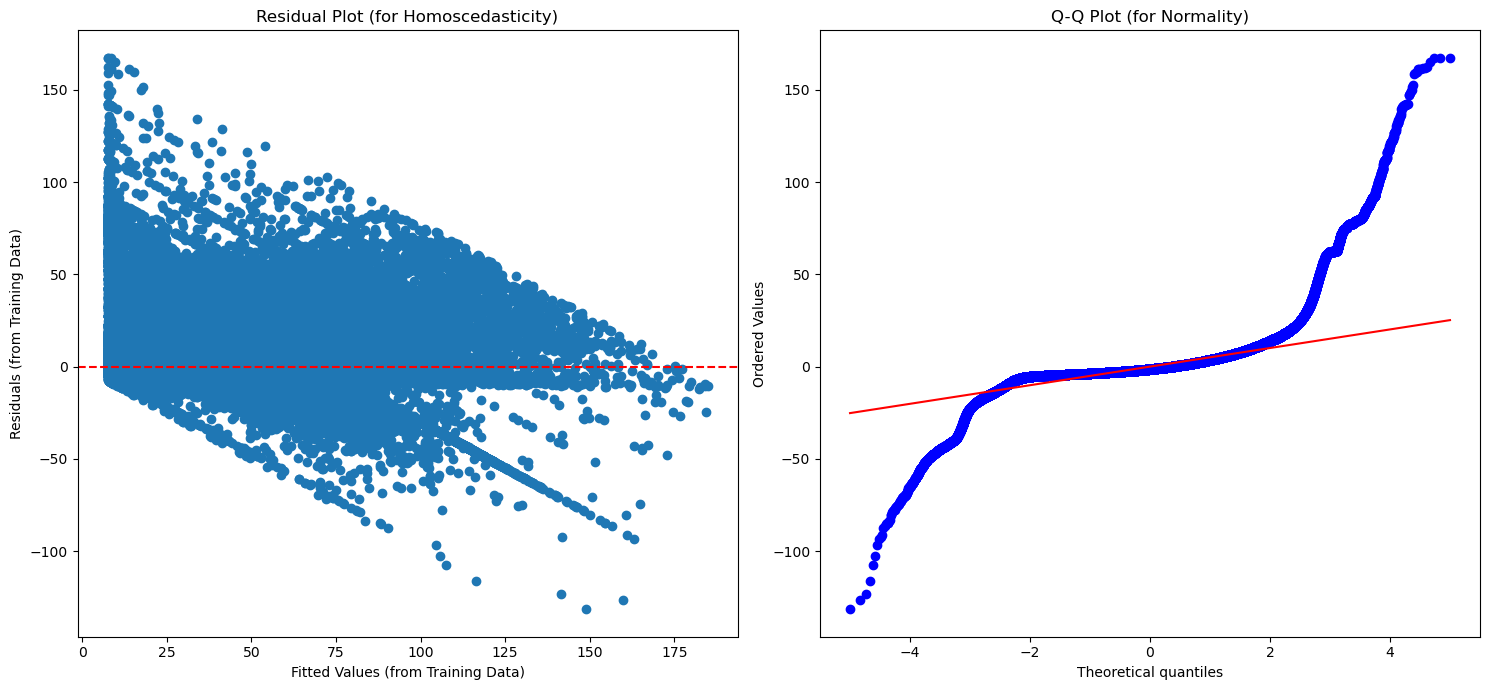

In [18]:
# Checking assumptions using the training data model 
# Residuals from the model trained on X_train, y_train
train_residuals = model.resid 

# 1. Plot for Homoscedasticity
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--',)
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

In [19]:
display(model.summary())
display(model_slr.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 8.061e+06
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:32:26   Log-Likelihood:            -7.8053e+06
No. Observations:             2411461   AIC:                         1.561e+07
Df Residuals:                 2411458   BIC:                         1.561e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.1868      0.008    908.411      0.000       7.171       7.202
trip_distance       3.6575      0.001   4007.996      0.000       3.656       3.659
passenger_count     0.2772      0.004     63.136      0.000       0.269       0.286
==============================================================================
Omnibus:                  2290588.490   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        276294845.808
Skew:                           4.266   Prob(JB):                         0.00
Kurtosis:                      54.740   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 2.015e+07
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:32:26   Log-Likelihood:            -9.7558e+06
No. Observations:             3014327   AIC:                         1.951e+07
Df Residuals:                 3014325   BIC:                         1.951e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5729      0.004   1695.328      0.000       7.564       7.582
trip_distance     3.6601      0.001   4489.047      0.000       3.659       3.662
==============================================================================
Omnibus:                  2860636.864   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        346209043.003
Skew:                           4.258   Prob(JB):                         0.00
Kurtosis:                      54.807   Cond. No.                         6.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
model.params

const             7.1868
trip_distance     3.6575
passenger_count   0.2772
dtype: float64

In [21]:
model_slr.params

const           7.5729
trip_distance   3.6601
dtype: float64

## We Share — Reflection & Wrap‑Up
Write **2 short paragraphs** and be specific:


1) **Which model would you trust today—MLR or SLR—and why?**
Use **test MAE/RMSE (units)**
- Today, I trust the MLR model, because it helps us realy understand the true effect on the response variable by holding other constante. in order words, It an advanced version of SLR, giving a more complete and realistic picture of the prediction we want to do, and understandinf how the outcome is inflyenced by many factors. the MAE (Test) gives us 3.63, meaning on average, the predicted fare is about $5 different from the actual fare. Also - RMSE (Test) is 6.12, this large error indicates that some predictions can be around $6 or more.

2) **What’s next to improve reliability?**
Options: add a more relevant predictor, use a **time‑aware split**, segment by ride type (airport vs. city), or prepare for **VIF/regularization** to handle collinearity.